# KAN UNET encoder

In [267]:
from kan import KAN

In [268]:
from kan_convolutional.KANConv import KAN_Convolutional_Layer

In [269]:
import torch
from torch import nn
import torch.nn.functional as F

In [271]:
import numpy as np

In [272]:
class UNET_KAN_encoder(nn.Module):
    def __init__(self, num_filters):
        super().__init__()
        
        self.KANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters, #changed from in channels to this
            kernel_size = (3,3),
            padding = (1,1),
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride = 2,
        )

    def forward(self, x):
        x = self.KANconv_1(x)
        
        x = self.pool1(x)

        return x

In [273]:
class UNET_KAN_decoder(nn.Module):
    def __init__(self, num_filters, in_channels, out_channels, skip_features):
        super().__init__()
        self.DKANconv_1 = KAN_Convolutional_Layer(
            n_convs = num_filters,
            kernel_size = (3,3),
            padding = (1,1),
        )

        self.ReduceChannels = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1)
        
        self.DKANconv_2 = KAN_Convolutional_Layer(
             n_convs = num_filters,
             kernel_size = (3,3),
             padding = (1,1),
        )
    def forward(self, x, skip_features):
        #Increase image size
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #Make skip features match dimensions of upscaled input
        if skip_features != None:
            skip_features = nn.functional.interpolate(skip_features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True) #changed from bilinear to nearest and removed 'align_corners=True'
            
            x = torch.cat((x, skip_features), dim=1)

        
        x = self.DKANconv_1(x)
        x = self.DKANconv_2(x)
        x = self.ReduceChannels(x)

        return x

In [275]:
class KAN_UNET(nn.Module):
    def __init__(self, input_shape=(3,256,256), num_classes=1, in_channels=1, out_channels=3):
        super().__init__()

        self.encoder1 = UNET_KAN_encoder(num_filters = 1)
        self.encoder2 = UNET_KAN_encoder(num_filters = 1) 
        # self.encoder3 = UNET_KAN_encoder(num_filters = 2)
        
        self.decoder1 = UNET_KAN_decoder(num_filters = 1, in_channels = 6, out_channels = 4, skip_features=None)
        self.decoder2 = UNET_KAN_decoder(num_filters = 2, in_channels = 28, out_channels = 3, skip_features=None)

        self.output_conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)


        # self.skip_emb1 = nn.Parameter(torch.randn(1, 12, 32, 32))
        # self.skip_emb2 = nn.Parameter(torch.randn(1, 6, 64, 64))
        # self.skip_emb3 = nn.Parameter(torch.randn(1, 3, 128, 128)) #Tried learnable skip embeddings to help decoder with images generated in latent space but didnt work

    def forward(self, x):
        print(f"Input Shape: {x.shape}")
        s1 = self.encoder1(x)
        print(f"Shape s1: {s1.shape}")
        s2 = self.encoder2(s1)
        print(f"Shape s2: {s2.shape}")
        # s3 = self.encoder3(s2)
        # print(f"Shape s3: {s3.shape}")
        
        d1 = self.decoder1(s2, s1)
        print(f"Shape d1: {d1.shape}")
        d2 = self.decoder2(d1, s2)
        print(f"Shape d2: {d2.shape}")
        # d3 = self.decoder3(d2, s3)
        # print(f"Shape d3: {d3.shape}")
        
        outputs = self.output_conv(d2)
        print(f"Output Shape: {outputs.shape}")
        return outputs, s2

    def encoding_block(self, x):
        with torch.no_grad():
            s1 = self.encoder1(x)
            s2 = self.encoder2(s1)
            # s3 = self.encoder3(s2)
        return s2

    def decoding_block(self, x):
        with torch.no_grad():
            
            print(f'Input shape: {x.shape}')
            d1 = self.decoder1(x, skipemb[0])
            print(f'd1 shape: {d1.shape}')
            d2 = self.decoder2(d1, skipemb[1])
            print(f'd2 shape: {d2.shape}')
            # d3 = self.decoder3(d2, skipemb[2])
            # print(f'd1 shape: {d3.shape}')
            output = self.output_conv(d2)
        return output

## Testing before training

In [355]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

def dispimage(img, title=" "):
    try:
        img_disp = (img.squeeze(0).detach()).numpy()
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(title)
        plt.imshow(img_disp[-1], cmap='gray')
        plt.axis("off")
        plt.show()
    except:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.title(title)
        plt.imshow(img, cmap='gray')
        plt.axis("off")
        plt.show()

def load_image(image_path, input_shape):
    image = Image.open(image_path).convert('RGB')
    
    transform = transforms.Compose([
        transforms.Resize(input_shape[1:]),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    
    image_tensor = transform(image).unsqueeze(0)
    return image_tensor

modelnotrain = KAN_UNET(input_shape=(3, 128, 128),num_classes=1, in_channels=3,out_channels=3)  #latent_dim=16)
modelnotrain.eval()


image_path = '/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Dataset/00004.png'
input_tensor = load_image(image_path, input_shape=(3, 128, 128))

In [291]:
with torch.no_grad():
    outputnotrain, s4_1 = modelnotrain(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [292]:
output_imagenotrain = (outputnotrain.squeeze(0).detach()).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


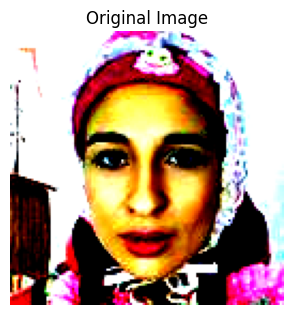

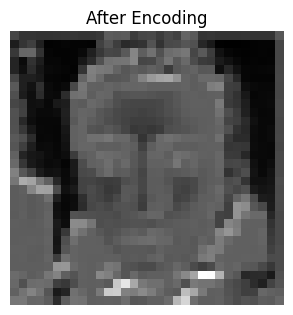

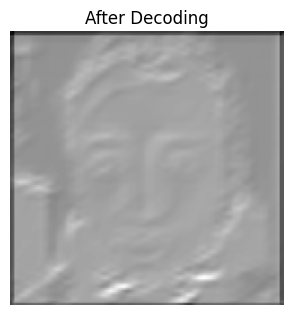

In [293]:
input_image = input_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)

dispimage(input_image, "Original Image")

dispimage(s4_1[0].squeeze(0).detach().numpy()[2], "After Encoding")

dispimage(output_imagenotrain[0], "After Decoding")

## Training

In [294]:
import os
from PIL import Image
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
import torchvision.transforms as transforms

In [295]:
class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.directory = directory
        self.transform = transform
        self.image_files = [f for i, f in enumerate(os.listdir(directory)) if f.endswith(('jpg', 'png', 'jpeg')) and i < 101]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

In [296]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [297]:
dataset_path = "/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Dataset"

dataset = ImageDataset(directory=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [298]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
model = KAN_UNET(input_shape=(3, 128, 128),num_classes=1, out_channels=3, in_channels=3).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

Training on cpu


In [299]:
model.load_state_dict(torch.load("/Users/haziq/Desktop/Projects/DIFFUSION_FROM_SCRATCH/Encoder_Decoder_model_weights.pth"), strict=True)

<All keys matched successfully>

In [38]:
epochs = 10

In [39]:
losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for i, batch in enumerate(tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")):
        inputs = batch  # No labels, only images
        inputs = inputs.to(device)

        
        outputs, _ = model(inputs, imgnum=i, totimg=101)

        
        loss = criterion(outputs, inputs)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"IMAGE LOSS: {loss.item()}")


    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")
    losses.append(running_loss)
    torch.save(model.state_dict(), 'Encoder_Decoder_model_weights.pth') #In case kernel dies


Epoch 1/10:   0%|                                       | 0/101 [00:00<?, ?it/s]

Output removed for better readability.

In [41]:
for i, loss in enumerate(losses):
    print(f"Epoch {i} Loss: {loss / len(dataloader)}")

0.11090372486205974
0.03171573808914659
0.02516382

Output removed for better readability.

## Test after training

In [301]:
with torch.no_grad():
    output_aftertrain, s3_aftertrain = model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 3, 64, 64])
Shape s2: torch.Size([1, 3, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 3, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [302]:
output_image_aftertrain = (output_aftertrain.squeeze(0).detach()).numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


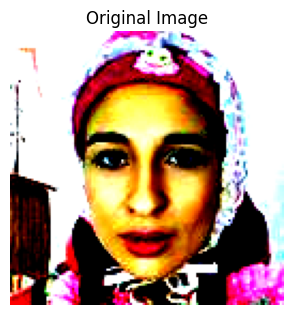

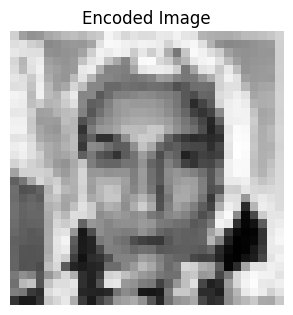

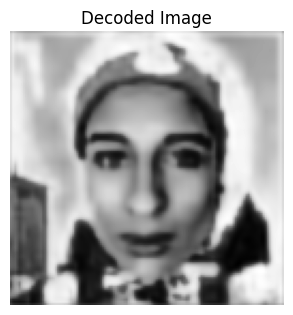

In [303]:
dispimage(input_image, "Original Image")
dispimage(s3_aftertrain.squeeze(0).detach().numpy()[2], "Encoded Image")
dispimage(output_image_aftertrain[2], "Decoded Image")

## Analyzing Model

In [304]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
pytorch_total_params

847

# Comparing with traditional Variational Auto Encoder

## Encoder

In [305]:
class UNET_encoder(nn.Module):
    def __init__(self,in_channels, out_channels):
        super().__init__()
        
        self.conv_1 = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size = (3,3),
            padding = 1,
        )

        self.pool1 = nn.MaxPool2d(
            kernel_size=2,
            stride = 2,
        )

    def forward(self, x):
        x = self.conv_1(x)
        
        x = self.pool1(x)

        return x

In [306]:
class UNET_decoder(nn.Module):
    def __init__(self, skip_features):
        super().__init__()
        self.Dconv_1 = nn.Conv2d(
            8,
            3,
            kernel_size = (3,3),
            padding = 1,
        )

        self.ReduceChannels = nn.Conv2d(
            3,
            4,
            kernel_size=1) #Dont need this anymore but keep it just for sake of experimentation
        
        self.Dconv_2 = nn.Conv2d(
            3,
            3,
            kernel_size = (3,3),
            padding = (1,1),
        )
        
    def forward(self, x, skip_features):
        #Increase image size
        x = nn.functional.interpolate(x, scale_factor=2, mode='bilinear', align_corners=True)
        #Make skip features match dimensions of upscaled input
        if skip_features != None:
            skip_features = nn.functional.interpolate(skip_features, size=(x.shape[2], x.shape[3]), mode='bilinear', align_corners=True) #changed from bilinear to nearest and removed 'align_corners=True'
            
            x = torch.cat((x, skip_features), dim=1)

        
        x = self.Dconv_1(x)
        x = self.Dconv_2(x)
        x = self.ReduceChannels(x)

        return x

In [331]:
class UNET(nn.Module):
    def __init__(self, input_shape=(3,128,128), num_classes=1, in_channels=3, out_channels=3):
        super().__init__()

        self.encoder1 = UNET_encoder(in_channels=in_channels,out_channels=out_channels)
        self.encoder2 = UNET_encoder(in_channels=4,out_channels=out_channels) 
        # self.encoder3 = UNET_KAN_encoder(num_filters = 2)
        
        self.decoder1 = UNET_decoder(skip_features=None)
        self.decoder2 = UNET_decoder(skip_features=None)
        
        self.output_conv = nn.Conv2d(in_channels=4, out_channels=3, kernel_size=1) #Dont need again but for sake of experimentation


        # self.skip_emb1 = nn.Parameter(torch.randn(1, 12, 32, 32))
        # self.skip_emb2 = nn.Parameter(torch.randn(1, 6, 64, 64))
        # self.skip_emb3 = nn.Parameter(torch.randn(1, 3, 128, 128)) #Tried learnable skip embeddings to help decoder with images generated in latent space but didnt work

    def forward(self, x):
        print(f"Input Shape: {x.shape}")
        s1 = self.encoder1(x)
        print(f"Shape s1: {s1.shape}")
        s2 = self.encoder2(s1)
        print(f"Shape s2: {s2.shape}")
        # s3 = self.encoder3(s2)
        # print(f"Shape s3: {s3.shape}")
        
        d1 = self.decoder1(s2, s1)
        print(f"Shape d1: {d1.shape}")
        d2 = self.decoder2(d1, s2)
        print(f"Shape d2: {d2.shape}")
        # d3 = self.decoder3(d2, s3)
        # print(f"Shape d3: {d3.shape}")
        
        outputs = self.output_conv(d2)
        print(f"Output Shape: {outputs.shape}")
        return outputs, s2

    def encoding_block(self, x):
        with torch.no_grad():
            s1 = self.encoder1(x)
            s2 = self.encoder2(s1)
            # s3 = self.encoder3(s2)
        return s2

    def decoding_block(self, x):
        with torch.no_grad():
            print(f'Input shape: {x.shape}')
            d1 = self.decoder1(x, skipemb[0])
            print(f'd1 shape: {d1.shape}')
            d2 = self.decoder2(d1, skipemb[1])
            print(f'd2 shape: {d2.shape}')
            # d3 = self.decoder3(d2, skipemb[2])
            # print(f'd1 shape: {d3.shape}')
            output = self.output_conv(d2)
        return output

In [332]:
baseline_model = UNET(input_shape=(3, 128, 128), out_channels=4)

In [333]:
params = sum(p.numel() for p in baseline_model.parameters() if p.requires_grad == True)
params

913

In [334]:
test, s2 = baseline_model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


In [335]:
test.shape

torch.Size([1, 3, 128, 128])

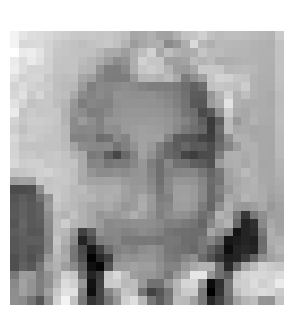

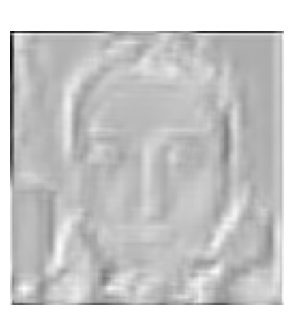

In [336]:
dispimage(s2)
dispimage(test)

In [357]:
epochs=100

In [358]:
print(f"Training on {device}")
criterion = nn.MSELoss()
optimizer = optim.Adam(baseline_model.parameters(), lr=0.01)

Training on cpu


In [359]:
losses = []
for epoch in range(epochs):
    baseline_model.train()
    running_loss = 0.0

    for batch in tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}"):
        inputs = batch  # No labels, only images
        inputs = inputs.to(device)

        
        outputs, _ = baseline_model(inputs)

        
        loss = criterion(outputs, inputs)

        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"IMAGE LOSS: {loss.item()}")


    
    print(f"Epoch [{epoch + 1}/{epochs}], Loss: {running_loss / len(dataloader):.4f}")
    losses.append(running_loss/len(dataloader))
    torch.save(model.state_dict(), 'BASELINE_Encoder_Decoder_model_weights.pth') #In case kernel dies

Epoch 1/100:  10%|██▊                          | 10/101 [00:00<00:01, 49.28it/s]

Output removed for better readability.

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776

Output removed for better readability.

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776

Output removed for better readability.

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776

Output removed for better readability.

In [360]:
for i, loss in enumerate(losses):
    print(f"Epoch {i}: {loss/len(dataloader)}")

Epoch 0: 0.0002685180555639425
Epoch 1: 0.00014776

Output removed for better readability.

In [361]:
train, Ts2 = baseline_model(input_tensor)

Input Shape: torch.Size([1, 3, 128, 128])
Shape s1: torch.Size([1, 4, 64, 64])
Shape s2: torch.Size([1, 4, 32, 32])
Shape d1: torch.Size([1, 4, 64, 64])
Shape d2: torch.Size([1, 4, 128, 128])
Output Shape: torch.Size([1, 3, 128, 128])


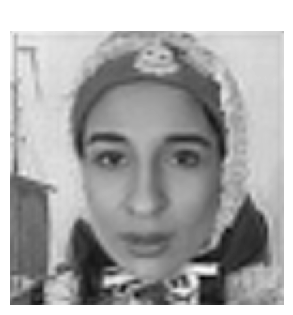

In [364]:
dispimage(train)